# Sequential data modelling
We have added a `?` in the exercises where you need to fill in.

In this notebook we will use RNNs to predict future temperature using the Jena weather dataset. We will start by using a SimpleRNN and then see whether we can improve our predictions using a GRU.

Before the modelling step we need to do our usual preprocessing. This time you will see a few things you have not seen before.

1. We will resample the data. The data consists of measurements every 10 minutes, we will instead select a datapoint every hour using the `seq()` function to select our data. We do this to make our training a little faster and have a somewhat meaningful problem.
1. We will see a different way to create sequences from a dataset. This approach is more dynamic than the reshape approach as it can produce more sequences than the reshape approach. Hopefully, it is also more intuitive.
1. We will not split our training data into a validation set, as we will leave that splitting up to Keras when we try to fit our data. Thus, we only split into train/test.

In short;
1. Load data and some cleaning.
1. Sub-sample data for every hour.
1. Create sequences.
1. Split data.
1. Scale data.
1. Baseline SimpleRNN
1. GRU RNN
1. LSTM RNN

In [1]:
library(keras)
library(ggplot2)
source("04-helpers.R")

use_multi_cpu(2L)
# This specifies the number of threads TensorFlow will use. You can change this number, 
# but it depends on the model, what the optimal number of threads might be.
# In my experiments 2 threads performed quite well for simpleRNNs.
# Using more than 2 threads increased communication overhead between CPUs and decreased the training speed.
# To change this value simply set the value which you want and then -
# click "Kernel" -> "Shutdown" and then "Kernel" -> "Restart".
# If you do not shutdown the kernel, the change will not take effect.

## 1. Load and clean data

In [2]:
raw_data <- load_jena_dataset()

Parsed with column specification:
cols(
  `Date Time` = col_character(),
  `p (mbar)` = col_double(),
  `T (degC)` = col_double(),
  `Tpot (K)` = col_double(),
  `Tdew (degC)` = col_double(),
  `rh (%)` = col_double(),
  `VPmax (mbar)` = col_double(),
  `VPact (mbar)` = col_double(),
  `VPdef (mbar)` = col_double(),
  `sh (g/kg)` = col_double(),
  `H2OC (mmol/mol)` = col_double(),
  `rho (g/m**3)` = col_double(),
  `wv (m/s)` = col_double(),
  `max. wv (m/s)` = col_double(),
  `wd (deg)` = col_double()
)


## Excercise 1
Remove the `Date Time` feature from `raw_data` and store the result in a variable called `data`. Verify your work using the `dim()` function. The data should have dimension `(420551, 14)`.

**Hint** `Date Time` is the first column in `raw_data`.

In [3]:
data <- raw_data[,-1]
dim(data)

[1] 420551     14

## 2. Sub-sampling
Let us now sub-sample our data by selecting every 6th data point. This will leave us with a data point for every hour instead of every 10 minutes.

To do this we will use slicing in conjunction with the [`seq()`](https://www.rdocumentation.org/packages/base/versions/3.5.3/topics/seq) to specify the indices we want to select. To see how it works, run the cell below.

In [4]:
vec = c(1,2,3,4,5,6)
odds = vec[seq(1, length(vec), 2)]
odds
evens = vec[seq(2, length(vec), 2)]
evens

[1] 1 3 5

[1] 2 4 6

## Exercise 2
Select every 6th datapoint from the dataset using the `seq()` function. Save the resampled data in a variable called `data_hourly`. Verify your work using the `dim()` function.

In [5]:
dim(data)
data_hourly = data[seq(1, nrow(data), 6),]
dim(data_hourly)

[1] 420551     14

[1] 70092    14

Like last week we want to predict the temperature, `T (degC)`. Let us plot that feature and see how the temperature varies over those years using the resampled dataset.

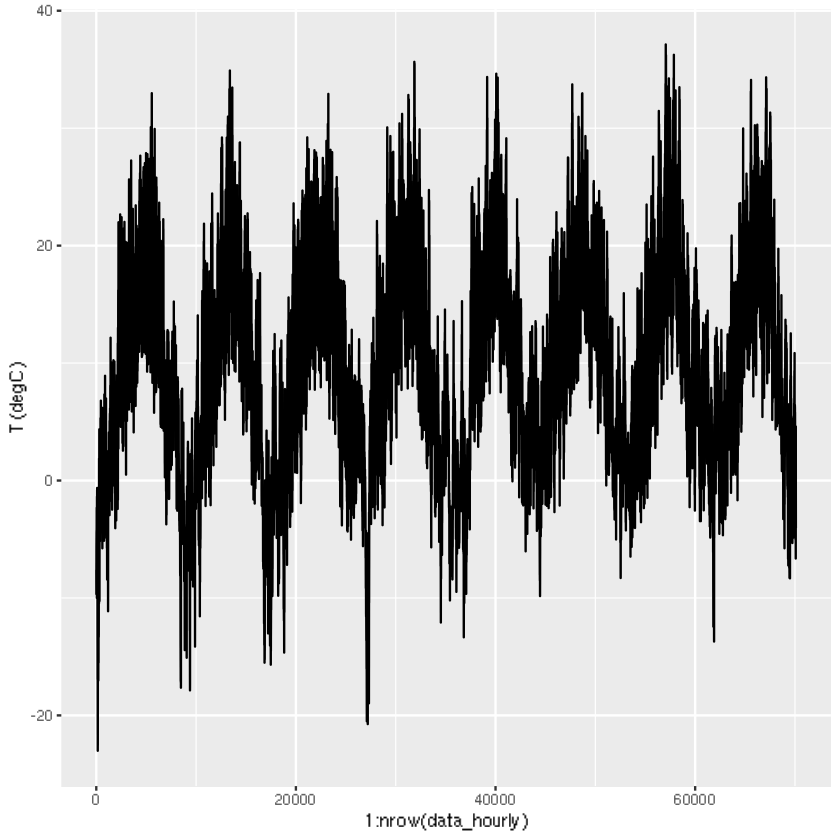

In [6]:
ggplot(data_hourly, aes(x = 1:nrow(data_hourly),y=`T (degC)`)) + geom_line()

## 3. Creating sequences
Now we will create sequences from the data using a function. The function accepts a number of parameters and returns a list containing two objects, the sequcences (`x`) and the targets (`y`).

Let us briefly explain what the parameters do. First you specify the `data` (the function expects 2D tensor / matrix) which is used to generate the sequences. The `sequence_length` is the length of the sequence to generate, each sequence will have that length. The `target_shift` is the number of time-steps between the end of each sequence until the target, the time-step we want to predict. The `step_shift` is the number of time-steps between the start of each sequence. The function will try to use as many datapoints as possible given the parameters to create the sequences.

Run the cell below to define the function and continue reading below. There is no need to read through the function and try to understand it. We just need to know how to use it.

In [7]:
create_sequences_x_y <- function(data, sequence_length, target_shift, step_shift) {
    data <- as.matrix(data)
    start_index = 1
    end_index = dim(data)[1]
    # We assume that the input is in legal ranges
    elements = end_index - start_index + 1
    # our targets are a single data point
    target_len = 1
    single_sequence_length = sequence_length + target_shift + target_len
    number_of_sequences = floor((elements - single_sequence_length)/step_shift) + 1
    
    # Initialise variables we need in the loop
    # We store the index which we should start with in each loop in current_start_index
    current_start_index = start_index
    sequence_x <- array(0, dim = c(number_of_sequences, sequence_length, dim(data)[2]))
    sequence_y <- array(0, dim = c(number_of_sequences, dim(data)[2]))
    for (sequence_index in 1:number_of_sequences) {
        # We get the current sequence data
        sequence_x[sequence_index,,] <- data[current_start_index:(current_start_index+sequence_length-1),]
        sequence_y[sequence_index,] <- data[(current_start_index+sequence_length+target_shift):(current_start_index+sequence_length+target_shift+target_len-1),]
        # We update our next start
        current_start_index <- current_start_index + step_shift
    }
    list(x = sequence_x, y = sequence_y)
}

## Exercise 3.1
To get a clearer idea of how this function works. Take the first 7 elements from `data_hourly` and pass it as `data` to the function. Set the `sequence_length` to 3, `target_shift` to 1 and `step_shift` to 1. The function returns a list which has two objects, `x` and `y`. Check the dimensions of `x` and `y` and see if they make sense.

In [8]:
sequence_test_data <- create_sequences_x_y(data = data_hourly[1:7,], sequence_length = 3, target_shift = 1, step_shift = 1)
dim(sequence_test_data$x)
sequence_test_data$x[1,,]
sequence_test_data$x[2,,]
sequence_test_data$x[3,,]
dim(sequence_test_data$y)
sequence_test_data$y[1,]
sequence_test_data$y[2,]
sequence_test_data$y[3,]
data_hourly[6,]
data_hourly[7,]

[1]  3  3 14

996.52,-8.02,265.40,-8.9,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
996.50,-7.62,265.81,-8.3,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
996.63,-8.85,264.57,-9.7,93.5,3.12,2.92,0.20,1.82,2.93,1312.11,0.16,0.50,158.3


996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
996.63,-8.85,264.57,-9.70,93.5,3.12,2.92,0.20,1.82,2.93,1312.11,0.16,0.50,158.3
996.87,-8.84,264.56,-9.69,93.5,3.13,2.92,0.20,1.83,2.93,1312.37,0.07,0.25,129.3


996.63,-8.85,264.57,-9.70,93.5,3.12,2.92,0.20,1.82,2.93,1312.11,0.16,0.50,158.3
996.87,-8.84,264.56,-9.69,93.5,3.13,2.92,0.20,1.83,2.93,1312.37,0.07,0.25,129.3
997.05,-9.23,264.15,-10.25,92.2,3.03,2.79,0.24,1.74,2.80,1314.62,0.10,0.38,203.9


[1]  3 14

[1]  997.05   -9.23  264.15  -10.25   92.20    3.03    2.79    0.24    1.74
[10]    2.80 1314.62    0.10    0.38  203.90

[1]  997.43   -9.67  263.68  -10.63   92.60    2.93    2.71    0.22    1.69
[10]    2.72 1317.35    0.36    0.75  132.50

[1]  997.81   -9.59  263.74  -10.47   93.20    2.95    2.74    0.20    1.71
[10]    2.75 1317.44    0.24    0.75  161.60

p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
997.43,-9.67,263.68,-10.63,92.6,2.93,2.71,0.22,1.69,2.72,1317.35,0.36,0.75,132.5


p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
997.81,-9.59,263.74,-10.47,93.2,2.95,2.74,0.2,1.71,2.75,1317.44,0.24,0.75,161.6


## Exercise 3.2
Copy your solution to exercise 3.1 and try using the first 8 (instead of 7) elements of `data_hourly` as `data`. What are the dimensions now? Does it make sense that a new sequence was added? What if we increase the `step_shift` to 2?

In [9]:
sequence_test_data <- create_sequences_x_y(data = data_hourly[1:8,], sequence_length = 3, target_shift = 1, step_shift = 1)
dim(sequence_test_data$x)
dim(sequence_test_data$y)

[1]  4  3 14

[1]  4 14

## Exercise 3.3
Now input all `data_hourly` as `data` and set the `sequence_length` to 96 (3 days), `target_shift` to 23 (23 hours) and `step_shift` to 24 (1 day). Store the `x` part of the output as `x_hourly` and `y` part as `y_hourly`. Check the dimensions.

In [10]:
sequence_data <- create_sequences_x_y(data = data_hourly, sequence_length = 96, target_shift = 23, step_shift = 24)
x_hourly <- sequence_data$x
y_hourly <- sequence_data$y
dim(x_hourly)
dim(y_hourly)

[1] 2916   96   14

[1] 2916   14

## Exercise 3.4
Notice that `y_hourly`, our targets, have 14 features in them. Since we only want to predict the temperature, we should remove all other features from `y_hourly` and save it as `y_hourly_temp`. Put differently, only keep the temperature feature. Verify the dimensions as always.

In [11]:
y_hourly_temp <- y_hourly[,2]
length(y_hourly_temp)

[1] 2916

## 4. Splitting
Now we split our data to train/test. Unlike usually, we will not split our data to a validation set. We will let Keras handle that for us in the `fit()` function.

Like above, we have provided a function which splits the data for you. The function accepts three parameters `x_data` and `y_data`, the data it is supposed to split and a `fraction`, the fraction of the data that should be used as test data. The function will select the last elements from the to create the test set. The function assumes that the number of rows in `x_data` and `y_data` is the same.

The function returns a list containing `x_train`, `y_train`, `x_test` and `y_test`.

In [12]:
split_dataset <- function(x_data, y_data, fraction = 0.2) {
    train_start_index <- 1
    train_end_index <- train_start_index + floor((1-fraction) * dim(x_data)[1]) - 1
    test_start_index <- train_end_index + 1
    test_end_index <- dim(x_data)[1]
    
    x_train <- x_data[train_start_index:train_end_index,,]
    x_test <- x_data[test_start_index:test_end_index,,]
    
    y_train <- y_data[train_start_index:train_end_index]
    y_test <- y_data[test_start_index:test_end_index]
    
    list(x_train = x_train,
        y_train = y_train,
        x_test = x_test,
        y_test = y_test)
}

## Exercise 4 
Use the function to split `x_hourly` and `y_hourly_temp`, using `fraction = 0.2`. 

In [13]:
split_data <- split_dataset(x_data = x_hourly, y_data = y_hourly_temp, fraction = 0.2)
x_train = split_data$x_train
y_train = split_data$y_train
x_test = split_data$x_test
y_test = split_data$y_test
dim(x_train)
length(y_train)
dim(x_test)
length(y_test)

[1] 2332   96   14

[1] 2332

[1] 584  96  14

[1] 584

## 5. Scaling
To help our network train faster, we need to scale our data. As in the previous weeks, we use the training set to scale the training and test sets. To scale a dataset we first needed to compute the mean and standard deviation, using only the training set. We use the [`apply()`](https://www.rdocumentation.org/packages/base/versions/3.5.3/topics/apply) function for this.

## Exercise 5
Fill in the apply function below to compute the mean and standard deviation of the training set.

In [14]:
# We compute the mean and sd for each feature independently.
mean <- apply(x_train, 3, mean)
std <- apply(x_train, 3, sd)

mean[2] # The mean temperature
mean[1] # The mean air pressure

[1] 8.991606

[1] 988.8198

Like last week, we cannot use the `scale()` function since it only works with (at most) 2D tensors, so we need to do this manually. Since we already split up the dataset into train/test, we need to scale both of them. We store the result in `x_train_scaled` and `x_test_scaled`. We provide the code for this, but we recommend reading through it.

In [15]:
# Create an empty 3D tensor with same dimensions as feature_matrix_reshaped.
x_train_scaled <- array(0, dim = dim(x_train))
x_test_scaled <- array(0, dim = dim(x_test))

# For each feature we subtract the mean and divide by the std.
for (j in 1:dim(x_train)[3]) {
    x_train_scaled[,,j] <- (x_train[,,j] - mean[j]) / std[j]
    x_test_scaled[,,j] <- (x_test[,,j] - mean[j]) / std[j]
}

Let us see if this all makes sense and check the first temperature.

In [16]:
x_train[1,1,2]
x_train_scaled[1,1,2]

[1] -8.02

[1] -2.015909

## 6. The models
Last week we used a dense network to serve as our baseline, this week we will use a SimpleRNN and then see if a GRU or an LSTM helps improve our predictions.

Notice that instead of providing validation data, we simply specify the fraction of training data to use for validation using the `validation_split = 0.2` parameter in the `fit()` function. According to the Keras documentation the [`fit()`](https://keras.io/models/sequential/) function will use the last elements of the training data (similar to what we have done for the test set). This is what we want, since we do not want to validate our data from the past. Also notice that our test data is even further ahead in the future.

## Exercise 6.1
- Create a network with a `simple_rnn_layer` with 16 units.
- After the simple RNN, create a regression layer.
- Use mae loss.
The `simple_rnn_layer` will need the `input_shape` parameter since it is the first layer in our network. We have shaped our input so that it has a sequence length of 96 and 14 features. You need to provide these values as the `input_shape`.

**Hint** To speed up training it is helpful to remove the `callbacks=list(Progress$new())` line from the `fit` function. The side-effect is that you have less idea of how far in the training process you are, but you can be sure that it is about 1/5 faster.

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
simple_rnn (SimpleRNN)              (None, 16)                      496         
________________________________________________________________________________
dense (Dense)                       (None, 1)                       17          
Total params: 513
Trainable params: 513
Non-trainable params: 0
________________________________________________________________________________


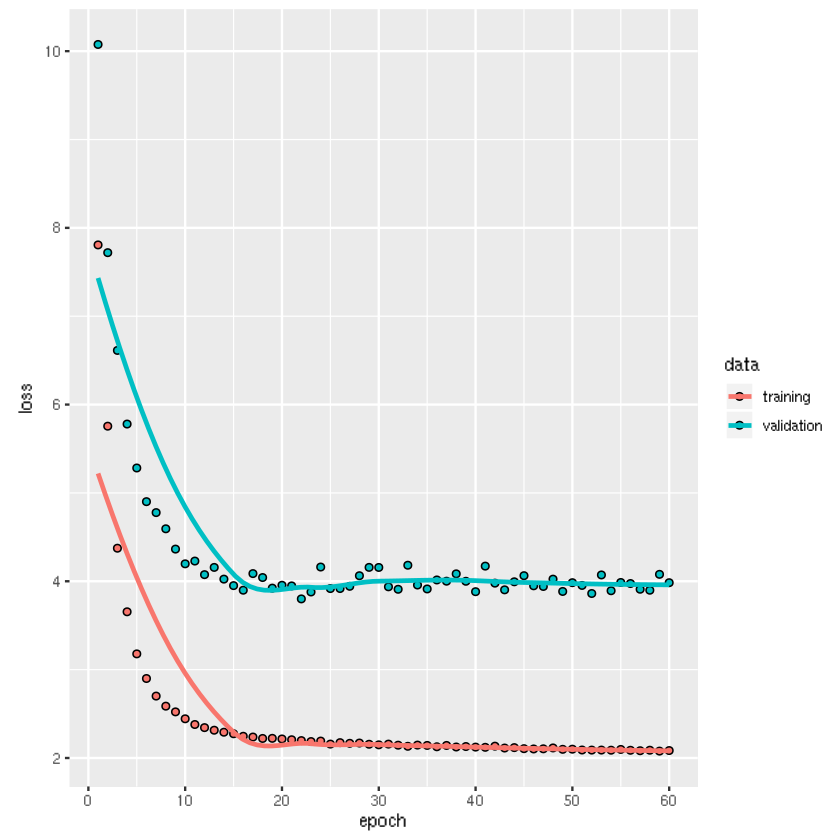

In [17]:
model <- keras_model_sequential() %>%
    layer_simple_rnn(units = 16, input_shape = c(96, 14)) %>%
    layer_dense(units = 1)

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.001),
    loss = "mae"
)

history <- model %>% fit(
    x = x_train_scaled,
    y = y_train,
    validation_split = 0.2,
    epochs = 60,
    batch_size = 16,
    callbacks=list(Progress$new())
)

plot(history)

We should see an average validation loss of about 4, we also see that the model seems to have started overfitting to the data. Usually, when we start overfitting to our data, we would not try a more expressive model as we would expect to overfit the data even more. Against our intution, let us try to use a GRU layer instead of a simple RNN.

## Exercise 6.2
Let us try a GRU layer instead of the SimpleRNN above. Copy the model above and only change the `layer_simple_rnn` to `layer_gru`. Notice that the GRU takes even longer to train.

Model: "sequential_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
gru (GRU)                           (None, 16)                      1488        
________________________________________________________________________________
dense_1 (Dense)                     (None, 1)                       17          
Total params: 1,505
Trainable params: 1,505
Non-trainable params: 0
________________________________________________________________________________


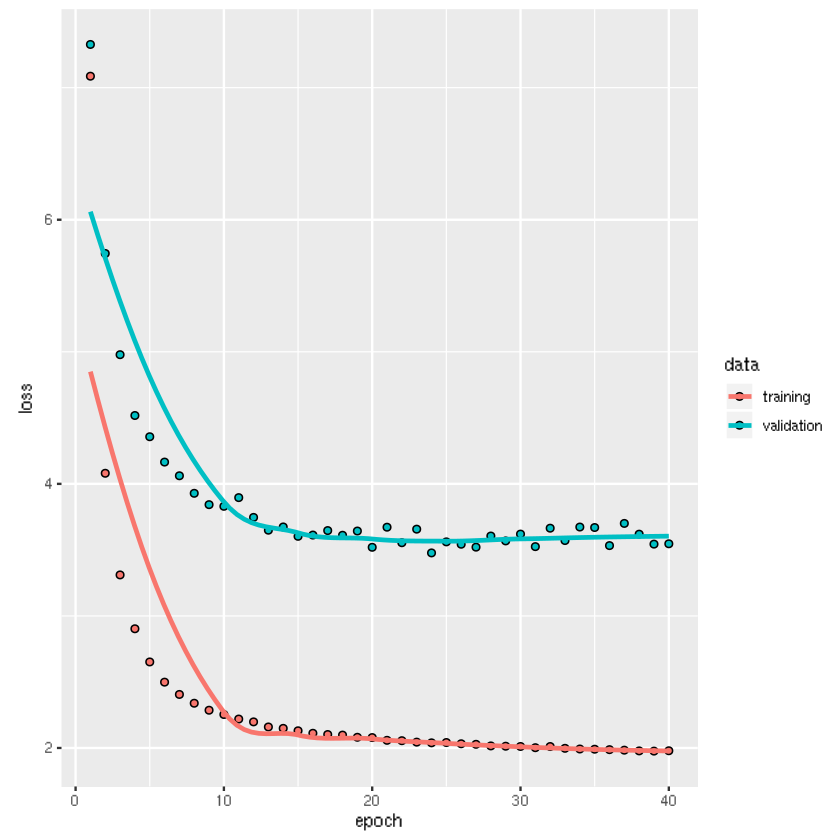

In [18]:
model <- keras_model_sequential() %>%
    layer_gru(units = 16, input_shape = c(96, 14)) %>%
    layer_dense(units = 1)

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.001),
    loss = "mae"
)

history <- model %>% fit(
    x = x_train_scaled,
    y = y_train,
    validation_split = 0.2,
    epochs = 40,
    batch_size = 16,
    callbacks=list(Progress$new())
)

plot(history)

Interesting! We see that the GRU actually outperforms the SimpleRNN and does not start overfitting the data. This seems to indicate that there were some long term dependenices which the SimpleRNN was not able to account for and it started overfitting to latest datapoints in the sequence.

Let us now compare evaluate our GRU against the test set by running the cell below. We will see that the test loss is similar to our validation loss, which is very good, it means that we have not methodologically overfit to the validation set.

In [19]:
model %>% evaluate(x_test_scaled, y_test)

loss 
3.400962

## Exercise 6.3
The test loss can be a bit abstract for us, so let us also manually compare the predictions of the model on the test set against the test labels. To get the predictions we use the function `predict()` and pass in the model as first parameter and then the `x_test_scaled` data. The function will output a predictions for each sequence in the test data. Store these predictions in a variable called `predictions`. Then combine the `predictions` column-wise with `y_test` using the function `cbind()`. Then print out the first 10 rows (using `head()`).

In [20]:
predictions <- model %>% predict(x_test_scaled)
compare <- cbind(predictions, y_test)
head(compare)

,y_test
12.417574,14.43
12.977946,11.55
9.026238,10.81
8.022478,13.77
9.299884,15.76
10.687099,12.38


You should see that "on average" we are about 3 degrees off, that is what the MAE loss of 3 means.

In this notebook we saw that the GRU did improve our predictions and it was very easy to adjust our original model to use a GRU instead. In the bonus exercise below, we suggest that you also try an LSTM, they tend to perform even better.

In this notebook we also saw three new things. First, we resampled the data so that we had a datapoint every hour using the `seq()` function. Second, we saw a different way to create sequences from a dataset. We created a helpful function for this which we can hopefully reuse in later notebooks. Third, we did not split our data into a validation set as we left it to Keras, which managed it for us in the `fit()` function.

## Bonus execrise
Copy the model from above and try using an LSTM instead of a GRU. Can you improve the performance. Does adding a dense layer after the LSTM help?

Model: "sequential_2"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
lstm (LSTM)                         (None, 32)                      6016        
________________________________________________________________________________
dense_2 (Dense)                     (None, 16)                      528         
________________________________________________________________________________
dense_3 (Dense)                     (None, 1)                       17          
Total params: 6,561
Trainable params: 6,561
Non-trainable params: 0
________________________________________________________________________________


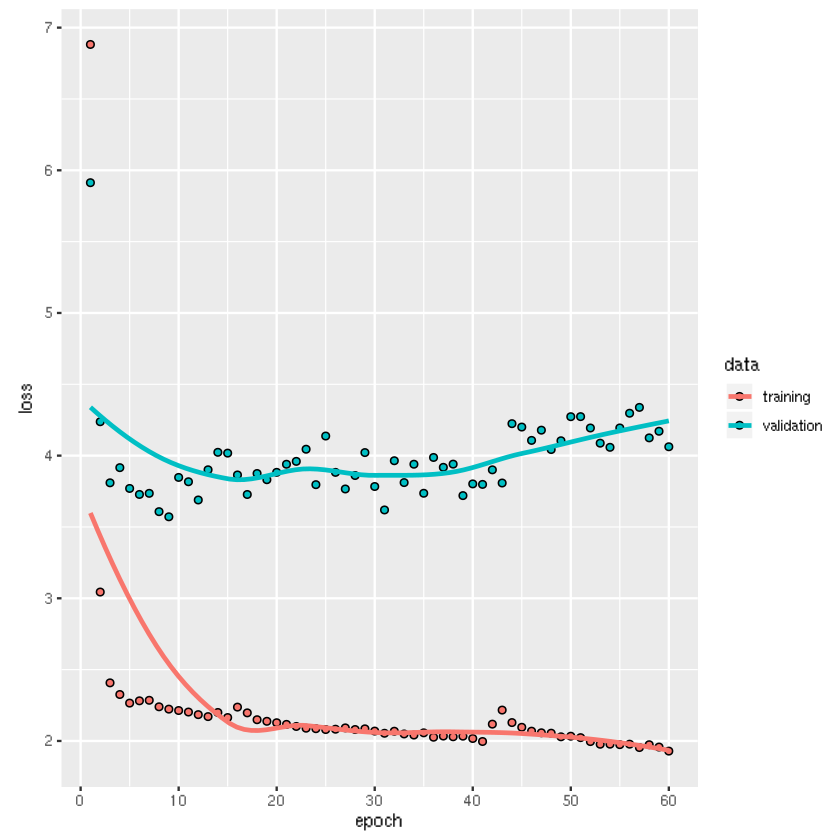

In [21]:
model <- keras_model_sequential() %>%
    layer_lstm(units = 32, input_shape = c(96, 14)) %>%
    layer_dense(units = 16, activation = 'relu') %>%
    layer_dense(units = 1)

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.001),
    loss = "mae"
)

history <- model %>% fit(
    x = x_train_scaled,
    y = y_train,
    validation_split = 0.2,
    epochs = 60,
    batch_size = 16,
    callbacks=list(Progress$new())
)

plot(history)